In [7]:
import pandas as pd
import numpy as np
import sklearn.ensemble
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
import warnings
import joblib
warnings.filterwarnings("ignore")
%matplotlib inline

In [8]:
import html,nltk
from nltk.corpus import wordnet 
from collections import Counter 
from string import digits
from nltk.stem.snowball import DanishStemmer

def text_cleaning(text, escape_list=[], stop=[]):
    """
    Text cleaning function:
    """
    text=text.lower()
    StopWords = list(set(stopwords.words('dutch')))
    custom_stop = StopWords + stop
    text = html.unescape(text)
    text = re.sub('[^A-Za-z]+', ' ', text)
#     text=text.replace('/',' ').replace('?',' ').replace(',',' ').replace('\'',' ')
    tokenz=nltk.word_tokenize(text)
    tokenz=([token for token in tokenz if token not in custom_stop]) 
    # remove_digits = str.maketrans('', '', digits)
#     tokenz=[DanishStemmer().stem(token) if token not in escape_list else token for token in tokenz ]
    return ' '.join(tokenz)

def get_prediction(model,X_train,y_train,X_test,y_test):
    y_pred_trn = model.predict(X_train)
    conf_mat = confusion_matrix(y_train, y_pred_trn)
    print(f'Accuracy for Training Set is  : {accuracy_score(y_train, y_pred_trn)}')
    print(f'Confusion Matrix for Training Set :\n {conf_mat} \n\n Classification Report for Training Set: \n')
    print(classification_report(y_train, y_pred_trn))
    print('--'*50)
    y_pred_tst = model.predict(X_test)
    conf_mat_tst = confusion_matrix(y_test, y_pred_tst)
    print(f'Accuracy for Testing Set is  : {accuracy_score(y_test, y_pred_tst)}')
    print(f'Confusion Matrix for Testing Set :\n {conf_mat_tst} \n\n Classification Report for Testing Set: /n')
    print(classification_report(y_test, y_pred_tst))

In [9]:
df = pd.read_csv("../data/court_cases.csv", lineterminator='\n', index_col=0)
df['Full Text'] = df['process'] + ' ' + df['considerations']
df.dropna(subset=['Full Text'],inplace=True)
df = df.sample(frac=1).reset_index(drop=True).copy()
df['Full Text'] = df['Full Text'].apply(text_cleaning)

In [10]:
X,y = df['Full Text'], df.outcome
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=3)

## Training SVM

In [5]:
# rsc = joblib.load('../models/rsc_tfidf_svm_ngram_1_1.pkl')

In [18]:
params = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'svm__C': [0.001,0.01,0.1,10,100,100],
    'svm__class_weight' : ['balanced',None]
}

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,1))
svm = LinearSVC()
pipeline = Pipeline(steps = [('tfidf',tfidf),('svm',svm)])
skf_cv = StratifiedKFold(n_splits=5)
rsc = RandomizedSearchCV(pipeline,params,cv= skf_cv,scoring='accuracy', random_state=0,n_jobs=-1)
rsc.fit(X,y)
print(f'Best CrossValidated accuracy achieved via SVM is : {round(rsc.best_score_*100,2)} %')
joblib.dump(rsc,'../models/rsc_tfidf_svm_ngram_1_1.pkl')

Best CrossValidated accuracy achieved via SVM is : 79.55 %


['../models/rsc_tfidf_svm_ngram_1_1.pkl']

In [6]:
# Best params for SVM is: 
rsc.best_params_

{'tfidf__max_df': 0.5, 'svm__class_weight': None, 'svm__C': 0.1}

In [38]:
feature_names = rsc.best_estimator_.named_steps["tfidf"].get_feature_names()
feature_importance = rsc.best_estimator_.named_steps["svm"].coef_.flatten()
fi = pd.DataFrame({'FeatureNames':feature_names,'FeatureImportance':feature_importance}).sort_values('FeatureImportance')

In [ ]:
# fi['color'] = fi.FeatureImportance.apply(lambda x:'Positive' if x>=0 else 'Negative')

In [18]:
def plot_features_of_explained_model(imp):
#     imp = pd.DataFrame(exp.as_list(label=selected_label))
    imp = imp.copy()
    imp.set_index('FeatureNames',inplace=True)
    imp['color'] = imp['FeatureImportance'].apply(lambda x:'Positive' if x>=0 else 'Negative')
    imp['FeatureImportance'] = imp['FeatureImportance'].apply(abs)
    imp = imp.sort_values('FeatureImportance',ascending=False)[:50]
    sns.set(rc={'figure.figsize':(12,12)})
    palette = ["#55a868","#c44e52"]
    ax = sns.barplot(x=imp['FeatureImportance'], y=imp.index,hue=imp['color'],palette=palette, dodge=False,hue_order=["Positive", "Negative"]).set_title(f'Feature Importance :',fontsize=15)
    plt.show()

## Built-in Feature Importance - SVM

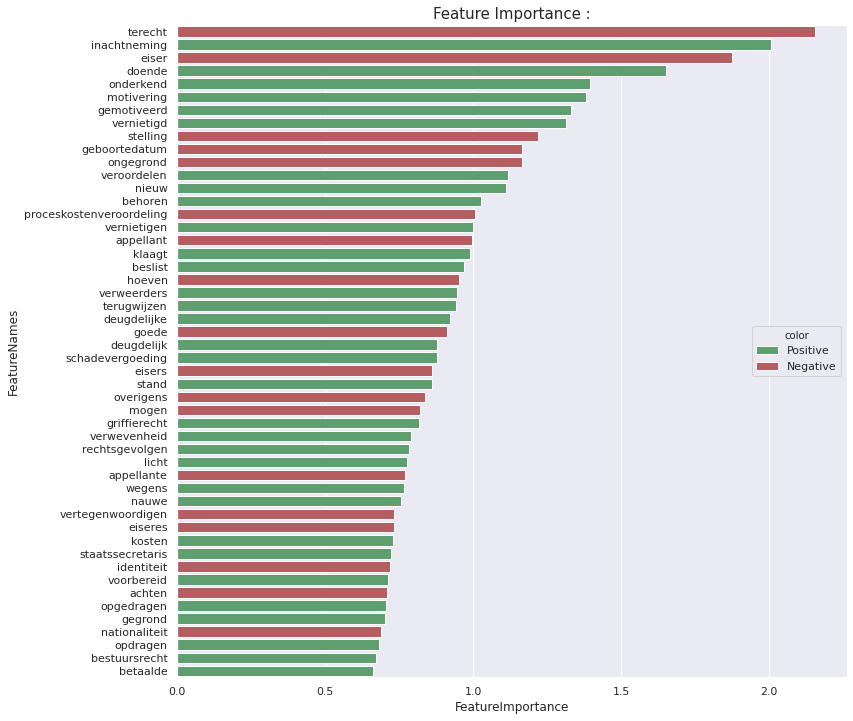

In [19]:
plot_features_of_explained_model(fi)

In [72]:
rsc.best_params_

{'tfidf__max_df': 0.5, 'svm__class_weight': None, 'svm__C': 0.1}

## Training with Best Params

In [7]:
pipeline_svm = Pipeline(steps = [('tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,1),max_df=.5)),
                        ('svm',CalibratedClassifierCV(LinearSVC(C=.1),method='isotonic'))])

pipeline_svm.fit(X,y)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ty='l2', random_state=None, tol=0.0001,
     verbose=0),
            cv='warn', method='isotonic'))])

In [60]:
# Saving the features
fi.FeatureImportance = fi.FeatureImportance.apply(abs)
fi.sort_values('FeatureImportance',ascending=False).to_csv('../features/svm_1_1_builtin.csv',index=False)

In [14]:
def get_feature_importance_for_full_document_parallel(X,y,idx,pipeline,num_features):
    '''
    Returns Importance as Class 0 Importance
    '''
#     print(f'Starting : {idx} {time.time()}')
#     print(idx)
    explainer = LimeTextExplainer(class_names=[0,1])
    exp = explainer.explain_instance(X, pipeline.predict_proba, num_features=num_features, labels=[0,1])
    imp = pd.DataFrame(exp.as_list(label=0),columns=['word','importance'])
    imp['ID'] = idx
    imp['Real Class'] = y
    imp['Predicted Class'] = pipeline.predict([X]).reshape(1,-1)[0,0]
    imp['Predicted Class Probability'] = pipeline.predict_proba([X]).max()
    return imp

In [13]:
import multiprocessing
import time
from tqdm import tqdm

def get_line_fi_multiprocessing(X,y,pipeline):
    start = time.time()

    with multiprocessing.Pool(processes=1) as pool:
        results = pool.starmap(get_feature_importance_for_full_document_parallel, [(X[idx],y[idx],idx,pipeline,500) for idx in range(len(X))])
        
    full_df = pd.concat(results)
    end = time.time()

    total_time = end - start
    print('Time :',total_time)
    print(f'With multiprocessing the job was finished in {int(total_time/3600)} hours {int(round(((total_time/3600)%1)*60,0))} minutes.')
    
    return full_df

In [17]:
lime_svm_fi = get_line_fi_multiprocessing(X,y,pipeline_svm)

In [ ]:
lime_svm_fi.to_csv('../features/svm_1_1_lime.csv.gz',index=False,compression='gzip')

## Training XGBOOST

In [4]:
rsc_xgb = joblib.load('../models/rsc_tfidf_xgb.pkl')

In [11]:
from xgboost import XGBClassifier

In [43]:
from xgboost import XGBClassifier

params_xgb = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
#     'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'xgb__eta': [0.01,0.015,0.025,0.05, 0.1],
    'xgb__gamma':[0.05,.1,.3,.5,.7,.9,1],
    'xgb__max_depth' : [3,5,7,9,12,15,17,25,50,100],
    'xgb__min_child_weight' : [1,3,5,7],
    'xgb__subsample' : [0.6,.7,.8,.9,1],
    'xgb__colsample_bytree' : [.6,.7,.8,.9,1],
    'xgb__lambda' : [0.01,.1,1],
    'xgb__alpha': [0,.1,.5,1]
}

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,1))
xgb = XGBClassifier()
pipeline_xgb = Pipeline(steps = [('tfidf',tfidf),('xgb',xgb)])
skf_cv = StratifiedKFold(n_splits=5)
rsc_xgb = RandomizedSearchCV(pipeline_xgb,params_xgb,cv= skf_cv,scoring='accuracy', random_state=0,n_jobs=-1)
rsc_xgb.fit(X,y)
print(f'Best CrossValidated accuracy achieved via SVM is : {round(rsc_xgb.best_score_*100,2)} %\n')
from pprint import pprint
print('XGB Best params : \n')
pprint(rsc_xgb.best_params_)
joblib.dump(rsc_xgb,'../models/rsc_tfidf_xgb.pkl')

Best CrossValidated accuracy achieved via SVM is : 83.43 %

XGB Best params : 

{'tfidf__max_df': 0.5,
 'xgb__alpha': 1,
 'xgb__colsample_bytree': 0.6,
 'xgb__eta': 0.01,
 'xgb__gamma': 0.3,
 'xgb__lambda': 0.01,
 'xgb__max_depth': 17,
 'xgb__min_child_weight': 3,
 'xgb__subsample': 0.7}


['../models/rsc_tfidf_xgb.pkl']

In [44]:
# feature_names = rsc_xgb.best_estimator_.named_steps["tfidf"].get_feature_names()
# feature_importance = rsc_xgb.best_estimator_.named_steps["xgb"].coef_.flatten()
# fi = pd.DataFrame({'FeatureNames':feature_names,'FeatureImportance':feature_importance}).sort_values('FeatureImportance')

In [45]:
feature_xgb = rsc_xgb.best_estimator_.named_steps["xgb"].get_booster().get_fscore()
vocab = rsc_xgb.best_estimator_.named_steps["tfidf"].vocabulary_
key_to_vocab = dict([(value, key) for key, value in vocab.items()]) 

In [46]:
feature_importance_dict_xgb = {key_to_vocab[int(key[1:])] : value for key,value in feature_xgb.items()}

In [47]:
feature_importance_df_xgb = pd.DataFrame(feature_importance_dict_xgb,columns=['Features','Importance'],index=range(len(feature_importance_dict_xgb)))

In [48]:
# pd.DataFrame.from_dict(feature_importance_dict_xgb)

In [49]:
xgb_feature_importance = pd.DataFrame(feature_importance_dict_xgb,index=range(len(feature_importance_dict_xgb))).T.iloc[:,0].to_frame('importance')
xgb_feature_importance.sort_values('importance',ascending=False,inplace=True)

In [30]:
xgb_feature_importance = xgb_feature_importance.iloc[:50,:]

## Feature Importance - Built-in - XGB

<AxesSubplot:xlabel='importance'>

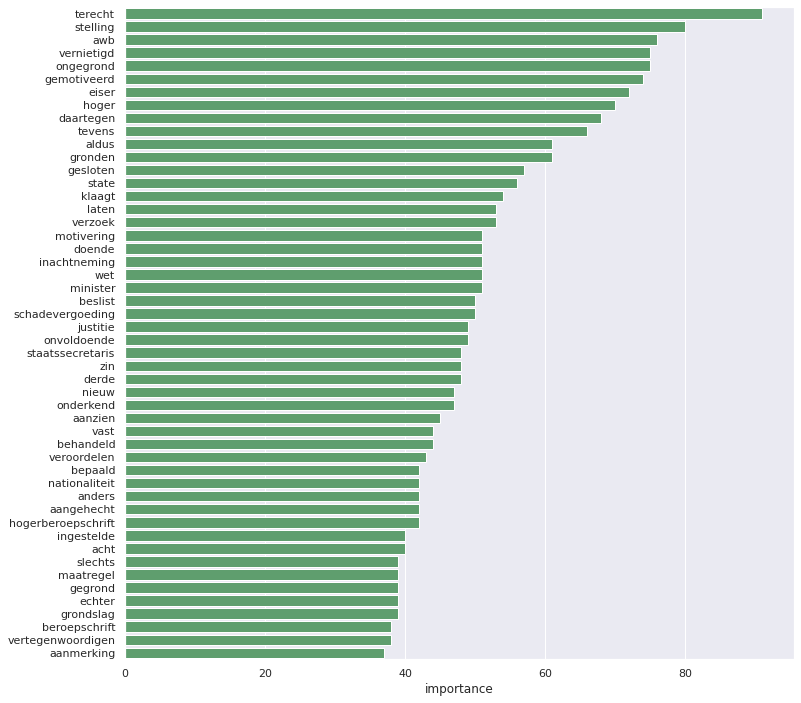

In [31]:
sns.barplot(x=xgb_feature_importance['importance'], y=xgb_feature_importance.index,palette=["#55a868"], dodge=False)

In [50]:
xgb_feature_importance.shape

(1375, 1)

In [55]:
xgb_feature_importance.reset_index(inplace=True)
# .to_csv('../features/xgb_1_1_builtin.csv')

In [57]:
xgb_feature_importance.columns = ['FeatureNames', 'FeatureImportance']

In [58]:
xgb_feature_importance.to_csv('../features/xgb_1_1_builtin.csv',index=False)

In [5]:
rsc_xgb.best_params_

{'xgb__subsample': 0.7,
 'xgb__min_child_weight': 3,
 'xgb__max_depth': 17,
 'xgb__lambda': 0.01,
 'xgb__gamma': 0.3,
 'xgb__eta': 0.01,
 'xgb__colsample_bytree': 0.6,
 'xgb__alpha': 1,
 'tfidf__max_df': 0.5}

In [ ]:
XG

In [12]:
pipeline_xgb = Pipeline(steps = [('tfidf',TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',ngram_range=(1,1),max_df=.5)),
                        ('xgb', XGBClassifier(subsample=.7,min_child_weight=3,max_depth=17,gamma=.3,eta=.01,colsample_bytree=.6,alpha=1))])

pipeline_xgb.fit(X,y)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.7, verbosity=1))])

In [ ]:
from tqdm import tqdm
xgb_fis = []
for idx in tqdm(range(len(X))):
    loop_fi = get_feature_importance_for_full_document_parallel(X[idx],y[idx],idx,pipeline_xgb,500)
    xgb_fis.append(loop_fi)
lime_xgb_fi = pd.concat(xgb_fis)

  3%|▎         | 273/8175 [33:55<18:52:40,  8.60s/it]

In [ ]:
# lime_xgb_fi = get_line_fi_multiprocessing(X[:2],y[:2],pipeline_xgb)

In [16]:
lime_xgb_fi.to_csv('../features/xgb_1_1_lime.csv.gz',index=False,compression='gzip')